In [3]:
import jax
import jax.numpy as jnp
import numpy as np

import hj_reachability as hj
from hj_reachability.finite_differences import upwind_first

from hjnnv import hjnnvUncertaintyAwareFilter
from dynamic_models.beacon import BeaconDynamics
from simulators.beacon_env.beacon_simulator import BeaconSimulator
from simulators.beacon_env.desired_trajectories import DesiredTrajectory

jax.config.update('jax_platform_name', 'cpu')

In [4]:
epsilon = 0.1
smoothing = True
smoothing_alpha = 0.7
dt = 0.05

dynamics = BeaconDynamics(
    dt=0.05,
    max_input=10.0,
    max_position_disturbance=0.00001,
    max_vel_disturbance=0.00001,
    range_disturbance=epsilon,
    model_name="simple_estimator_3t",
    random_seed=1
)

beacon_sim = BeaconSimulator(
    dynamics,
    epsilon=epsilon,
    smoothing=smoothing,
    smoothing_alpha=smoothing_alpha
)

100%|##########| 10.0000/10.0 [00:09<00:00,  1.09sim_s/s]


Step 0: Filter execution time: 2.18110 seconds
Step 1: Filter execution time: 0.00621 seconds
Step 2: Filter execution time: 0.00852 seconds
Step 3: Filter execution time: 0.00482 seconds
Step 4: Filter execution time: 0.00516 seconds
Step 5: Filter execution time: 0.00569 seconds
Step 6: Filter execution time: 0.00668 seconds
Step 7: Filter execution time: 0.00654 seconds
Step 8: Filter execution time: 0.00546 seconds
Step 9: Filter execution time: 0.00580 seconds
Step 10: Filter execution time: 0.00611 seconds
Step 11: Filter execution time: 0.00580 seconds
Step 12: Filter execution time: 0.00588 seconds
Step 13: Filter execution time: 0.00622 seconds
Step 14: Filter execution time: 0.00611 seconds
Step 15: Filter execution time: 0.00621 seconds
Step 16: Filter execution time: 0.00513 seconds
Step 17: Filter execution time: 0.00585 seconds
Step 18: Filter execution time: 0.00565 seconds
Step 19: Filter execution time: 0.00501 seconds
Step 20: Filter execution time: 0.00621 seconds
St

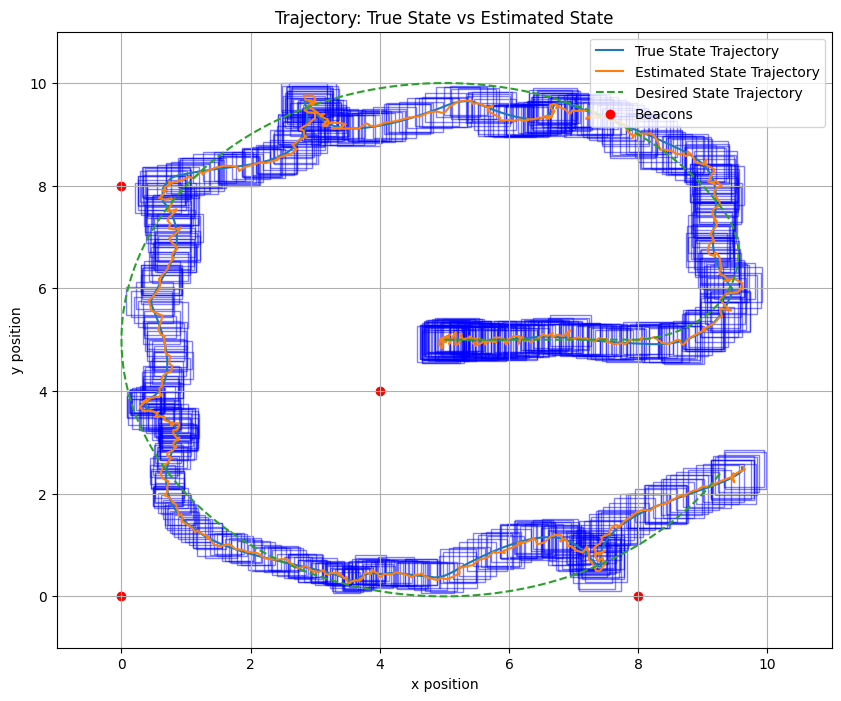

: 

In [ ]:
results_dict = beacon_sim.run(
    num_steps=100,
    filtering=False,
    bounding_method=None,
    experiment_number=1
)
beacon_sim.plot(
    results=results_dict,
    experiment_number=1,
    plot_type="trajectory"
)

In [10]:

state_history = []
state_hat_history = []
state_bounds_history = []
state_sample_history = []
state_des_history = []

seed = 1
traj_type = "spiral"
key = jax.random.PRNGKey(seed)
num_samples = 5000
dynamics.set_random_seed(seed)

if traj_type == "lawnmower":
    state = jnp.array([0.5, 0.5, 0.0, 0.0])  # initial state
    num_steps = 1650
elif traj_type == "spiral":
    state = jnp.array([5., 5., 0.0, 0.0])
    # num_steps = 650
    num_steps = 700
elif traj_type == "circle":
    state = jnp.array([8., 5., 0.0, 0.0])
    num_steps = 650
else:
    state = jnp.array([5.0, 5.0, 0.0, 0.0])  # initial state
    num_steps = 650

desired_traj = DesiredTrajectory(traj_type)
state_hat = state
u = rov_controller(state_hat, desired_traj, 0)

for step in range(num_steps):
    key, subkey = jax.random.split(key)
    t = step * dynamics.dt
    # Simulate the system dynamics
    if smoothing:
        obs = dynamics.get_observation(state, time=step)
        est_obs = jnp.concatenate([state_hat, u, obs])  # append previous state estimate and input
        state_hat = dynamics.get_smoothed_state_estimate(est_obs).flatten()
    else:
        obs = dynamics.get_observation(state, time=step)
        state_hat = dynamics.get_state_estimate(obs).flatten()
        

    state_bounds = hjnnv_filter.state_bounds_from_gt(
        jnp.array(state_hat),
        state
    )

    time_start = time.time()
    if smoothing:
        bound_epsilon = jnp.concatenate([1e-8*jnp.ones(6,), epsilon*jnp.ones(12,)])
        state_bounds = hjnnv_filter.nnv_state_bounds(
            obs=est_obs,
            eps=bound_epsilon
        )
    else:
        state_bounds = hjnnv_filter.nnv_state_bounds(
            obs=obs,
            eps=epsilon
        )

    u_nominal = rov_controller(state_hat, desired_traj, t)
    # v_star, u_star, worst_val, val_filter, min_vals, distances = hjnnv_filter.ua_filter_max_val(
    #     u_nominal,
    #     state_bounds,
    #     num_states=2,
    #     eps=1e-6
    # )
    v_star, u_star, worst_val, val_filter, min_vals, distances, _, _, = hjnnv_filter.ua_filter_best_u(
        u_nominal,
        state_bounds,
        num_states=2,
        delta=0.01
    )

    if val_filter < 0.0:
        u = u_star
        # print(f"Step {step}: Using filtered control u_star={u}, val_filter={val_filter}")
        # mask = min_vals >= (v_star - 1e-7)  # candidates within tolerance
        # print(f"Step {step}: min_vals_masked={jnp.where(mask, distances, jnp.inf)}")
        # best_idx = jnp.argmin(jnp.where(mask, distances, jnp.inf))
        # print(f"Step {step}: best_idx={best_idx}, u_best={hjnnv_filter.control_vals[best_idx]}, v_best={min_vals[best_idx]}, dist_best={distances[best_idx]}")
        # print(f"Step {step}: Max min_vals={max(min_vals)}")
    else:
        u = u_nominal
    time_end = time.time()

    obs_perturbations = jax.random.uniform(
        subkey, shape=(num_samples, obs.shape[0]),
        minval=-epsilon, maxval=epsilon
    )
    obs_samples = obs + obs_perturbations
    state_samples_0 = jax.vmap(lambda o: dynamics.get_state_estimate(o).flatten())(obs_samples)

    # state_samples_0 = jax.random.uniform(
    #     subkey, shape=(num_samples, state.shape[0]),
    #     minval=state_bounds.lo, maxval=state_bounds.hi
    # )

    disturbances = jax.vmap(lambda k: dynamics.get_random_disturbance())(
        jax.random.split(subkey, num_samples)
    )

    state_samples = jax.vmap(
        lambda s, d: dynamics.step(s, u_nominal, d, time=step)
    )(state_samples_0, disturbances)

    state_sample_history.append(state_samples)

    # print(f"Step {step}: State: {state}")
    # print(f"Step {step}: Estimated State: {state_hat}")

    # print(f"Step {step}: u_star={u}, val_filter={val_filter}")
    print(f"Step {step}: Filter execution time: {time_end - time_start:.5f} seconds")

    # Store the state
    # if step == 0:
    state_history.append(state)
    state_hat_history.append(state_hat)
    state_bounds_history.append(state_bounds)
    spline_x, spline_y = desired_traj.generate_trajectory()
    state_des_history.append(jnp.array([spline_x(t, 0), spline_y(t, 0), spline_x(t, 1), spline_y(t, 1)]))

    state = dynamics.step(state, u, dynamics.get_random_disturbance(), time=step)

Step 0: Filter execution time: 0.00621 seconds
Step 1: Filter execution time: 0.00604 seconds
Step 2: Filter execution time: 0.00600 seconds
Step 3: Filter execution time: 0.00510 seconds
Step 4: Filter execution time: 0.00489 seconds
Step 5: Filter execution time: 0.00602 seconds
Step 6: Filter execution time: 0.00569 seconds
Step 7: Filter execution time: 0.00543 seconds
Step 8: Filter execution time: 0.00485 seconds
Step 9: Filter execution time: 0.00484 seconds
Step 10: Filter execution time: 0.00536 seconds
Step 11: Filter execution time: 0.00508 seconds
Step 12: Filter execution time: 0.00664 seconds
Step 13: Filter execution time: 0.00528 seconds
Step 14: Filter execution time: 0.00498 seconds
Step 15: Filter execution time: 0.00637 seconds
Step 16: Filter execution time: 0.00495 seconds
Step 17: Filter execution time: 0.00507 seconds
Step 18: Filter execution time: 0.00522 seconds
Step 19: Filter execution time: 0.00598 seconds
Step 20: Filter execution time: 0.00579 seconds
St

In [202]:
u_nominal = jnp.array([0.0, 0.0])
lo = jnp.array([0.01, 5.0, -0.3, -0.0625])
hi = lo + 0.125
state_bounds = hj.sets.Box(lo, hi)
delta = .4

# v_star, u_star, worst_val, val_filter, min_vals, distances, any_above, best_idx = hjnnv_filter.ua_filter_best_u(
#     u_nominal,
#     state_bounds,
#     num_states=2,
#     delta=delta
# )
v_star, u_star, worst_val, val_filter, _, _ = hjnnv_filter.ua_filter_max_val(
    u_nominal,
    state_bounds,
    num_states=2
)
# distances[min_vals >= delta]
# new_best_idx = jnp.argmin(jnp.where(min_vals >= delta, distances, jnp.inf))
# new_best_idx
# distances[new_best_idx]
# # # distances[best_idx]
# hjnnv_filter.control_vals[new_best_idx]
u_star
bound_epsilon = jnp.concatenate([1e-6*jnp.ones(6,), epsilon*jnp.ones(12,)])
bound_epsilon

Array([1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-01, 1.e-01,
       1.e-01, 1.e-01, 1.e-01, 1.e-01, 1.e-01, 1.e-01, 1.e-01, 1.e-01,
       1.e-01, 1.e-01], dtype=float32)

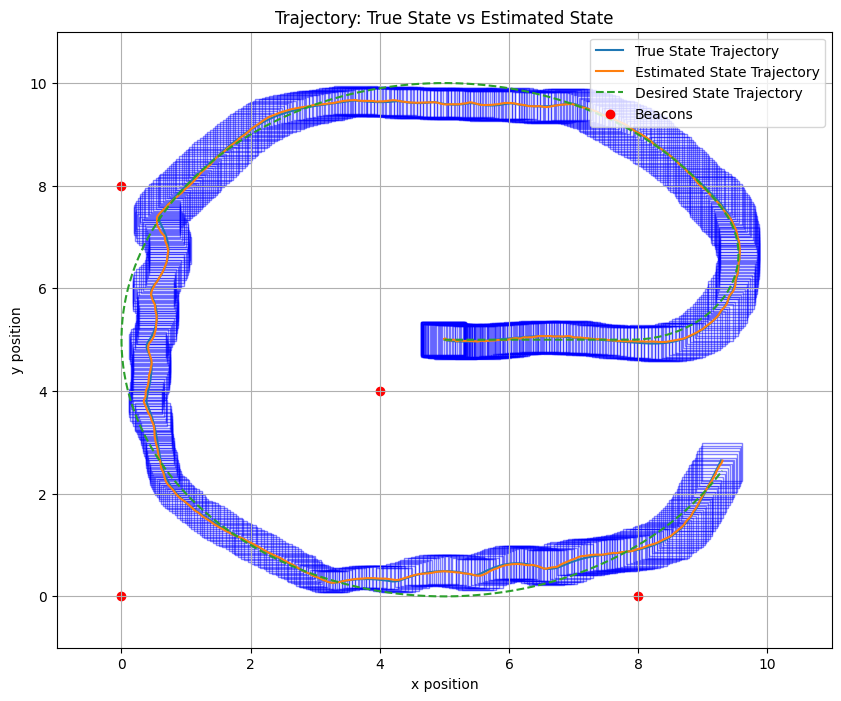

In [11]:
state_history = jnp.stack(state_history)
state_hat_history = jnp.stack(state_hat_history)

t_samples = np.linspace(0, num_steps * dynamics.dt, num_steps)
x_des_history = spline_x(t_samples, 0)
y_des_history = spline_y(t_samples, 0)



plt.figure(figsize=(10, 8))
plt.plot(state_history[:, 0], state_history[:, 1], label="True State Trajectory")
plt.plot(state_hat_history[:, 0], state_hat_history[:, 1], label="Estimated State Trajectory")
plt.plot(x_des_history, y_des_history, label="Desired State Trajectory", linestyle='--')
plt.scatter(dynamics.beacons[:, 0], dynamics.beacons[:, 1], c='red', marker='o', label="Beacons")
for i in range(len(state_bounds_history)):
    bounds = state_bounds_history[i]
    lo = bounds.lo
    hi = bounds.hi
    rect = plt.Rectangle(
        (lo[0], lo[1]),
        hi[0] - lo[0],
        hi[1] - lo[1],
        linewidth=1,
        edgecolor='b',
        facecolor='none',
        alpha=0.5
    )
    plt.gca().add_patch(rect)
plt.xlabel("x position")
plt.ylabel("y position")
plt.title("Trajectory: True State vs Estimated State")
plt.legend(loc="upper right")
plt.xlim(-1, 11)
plt.ylim(-1, 11)
plt.grid(True)
plt.show()

Animating frame 0/700
Animating frame 1/700
Animating frame 2/700
Animating frame 3/700
Animating frame 4/700
Animating frame 5/700
Animating frame 6/700
Animating frame 7/700
Animating frame 8/700
Animating frame 9/700
Animating frame 10/700
Animating frame 11/700
Animating frame 12/700
Animating frame 13/700
Animating frame 14/700
Animating frame 15/700
Animating frame 16/700
Animating frame 17/700
Animating frame 18/700
Animating frame 19/700
Animating frame 20/700
Animating frame 21/700
Animating frame 22/700
Animating frame 23/700
Animating frame 24/700
Animating frame 25/700
Animating frame 26/700
Animating frame 27/700
Animating frame 28/700
Animating frame 29/700
Animating frame 30/700
Animating frame 31/700
Animating frame 32/700
Animating frame 33/700
Animating frame 34/700
Animating frame 35/700
Animating frame 36/700
Animating frame 37/700
Animating frame 38/700
Animating frame 39/700
Animating frame 40/700
Animating frame 41/700
Animating frame 42/700
Animating frame 43/70

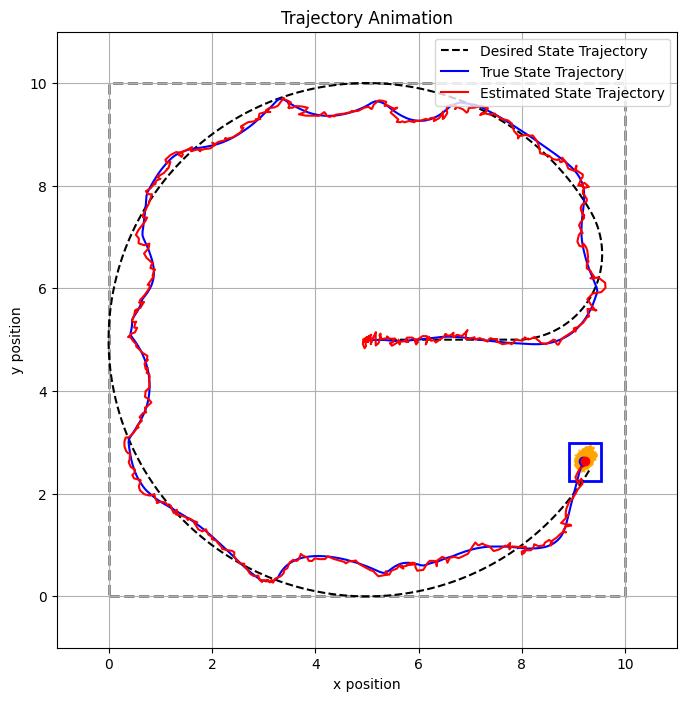

In [188]:
import matplotlib.animation as animation
import matplotlib.patches as patches

# Stack histories (already done at the end of your sim)
state_history = jnp.stack(state_history)
state_hat_history = jnp.stack(state_hat_history)
state_des_history = jnp.stack(state_des_history)

t_samples = np.linspace(0, num_steps * dynamics.dt, num_steps)
x_des_history = spline_x(t_samples, 0)
y_des_history = spline_y(t_samples, 0)

# Set up figure
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(-1, 11)
ax.set_ylim(-1, 11)
ax.set_xlabel("x position")
ax.set_ylabel("y position")
ax.set_title("Trajectory Animation")
ax.grid(True)

# Plot desired trajectory once (static)
ax.plot(x_des_history, y_des_history, 'k--', label="Desired State Trajectory")
ax.add_patch(patches.Rectangle((0, 0), 10, 10, linestyle='--', linewidth=2, edgecolor='grey', facecolor='none'))

# Lines that will be updated
true_line, = ax.plot([], [], 'b-', label="True State Trajectory")
hat_line, = ax.plot([], [], 'r-', label="Estimated State Trajectory")
true_point, = ax.plot([], [], 'bo', markersize=6)  # current true state
des_point, = ax.plot([], [], 'ko', markersize=6)  # current desired state
hat_point, = ax.plot([], [], 'ro', markersize=6)  # current estimated state
beacons, = ax.plot([], [], 'ko')
state_sample_points = ax.scatter([], [], c='orange', marker='.', s=1)

rect_patch = patches.Rectangle(
    (0, 0), 0, 0, linewidth=2, edgecolor='b', facecolor='none'
)
ax.add_patch(rect_patch)

ax.legend(loc="upper right")

# Init function for animation
def init():
    true_line.set_data([], [])
    hat_line.set_data([], [])
    true_point.set_data([], [])
    hat_point.set_data([], [])
    des_point.set_data([], [])
    beacons.set_data([], [])
    beacons.set_visible(False)
    state_sample_points.set_offsets(np.empty((0, 2)))
    # state_sample_points.set_visible(False)
    des_point.set_visible(False)
    rect_patch.set_visible(False)
    return true_line, hat_line, true_point, hat_point, beacons

# Update function for animation
def update(frame):
    print(f"Animating frame {frame}/{num_steps}")
    # Trails
    true_line.set_data(state_history[:frame, 0], state_history[:frame, 1])
    hat_line.set_data(state_hat_history[:frame, 0], state_hat_history[:frame, 1])
    # Current points (wrapped in lists!)
    true_point.set_data([state_history[frame, 0]], [state_history[frame, 1]])
    hat_point.set_data([state_hat_history[frame, 0]], [state_hat_history[frame, 1]])
    des_point.set_data([state_des_history[frame, 0]], [state_des_history[frame, 1]])

    beacons.set_data(dynamics.beacons[:, 0], dynamics.beacons[:, 1])

    # Rectangle bounds at this frame
    lo = state_bounds_history[frame].lo   # shape (2,) -> [x_lo, y_lo]
    hi = state_bounds_history[frame].hi   # shape (2,) -> [x_hi, y_hi]

    rect_patch.set_xy((lo[0], lo[1]))
    rect_patch.set_width(hi[0] - lo[0])
    rect_patch.set_height(hi[1] - lo[1])
    rect_patch.set_visible(True)

    state_sample_points.set_offsets(state_sample_history[frame])

    return true_line, hat_line, true_point, hat_point, des_point, rect_patch

# Create animation
ani = animation.FuncAnimation(
    fig, update, frames=len(state_history), init_func=init,
    blit=True, interval=20, repeat=False
)

ani.save("../results/beacon/circle/trajectory_min-ctrl-mod_seed0_smoothing0.7_eps0.1_spiral_debug.mp4", writer="ffmpeg", fps=10)

plt.show()